Cross-Language Rap Detector
---------------------------

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import pandas as pd
import pickle
import scipy.sparse
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.manifold import TSNE


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [67]:
def feature_distribution(data, which_feature):
    med = np.median(train_data.loc[:,which_feature])
    q75, q25 = np.percentile(train_data.loc[:,which_feature], [75 ,25])
    iqr = q75 - q25
    minx = med-(iqr*2.5)
    if minx < 0:
        minx = 0
    maxx = med+(iqr*2.5)
    nbins = 20
    bins = np.linspace(minx, maxx, nbins+1) 

    plt.figure()
    sns.distplot(data.loc[data.rap==0,which_feature], bins=bins, label='Non-rap')
    sns.distplot(data.loc[data.rap==1,which_feature], bins=bins, label='Rap')
    plt.xlim(minx, maxx)
    plt.title(which_feature)
    plt.legend()
    

In [3]:
with open('train_track_info.pickle','r') as f:
	track_info = pickle.load(f)
    
with open('train_lyrics_data.pickle','r') as f:
	lyrics = pickle.load(f)

In [4]:
# Reduce the number of non-rap training samples so that it is balanced with the rap training samples
y = track_info.loc[:,'rap']
num_rap_tracks = np.sum(y)
all_rap_artists = np.unique(track_info.loc[track_info.rap==1,'spotify_artist_id'])
all_nonrap_artists = np.unique(track_info.loc[track_info.rap==0,'spotify_artist_id'])


# Match the number of artists between the nonrap sample and the rap sample (otherwise the nonrap might have more variety of artists)
rs = cross_validation.ShuffleSplit(len(all_nonrap_artists), n_iter=1, test_size=len(all_rap_artists),random_state=7)
sampled_nonrap_artists =  next(iter(rs))[1]
non_rap_tracks = track_info.merge(right=pd.DataFrame(data={'spotify_artist_id':all_nonrap_artists[sampled_nonrap_artists]}),on='spotify_artist_id',how='inner')

# Since nonrap artists tended to have more songs in the set than rap artists, 
# still have to randomly sample tracks from across the non-rap tracks to match the number of
# rap and non-rap tracks
g=  track_info.groupby(by=['rap','spotify_artist_id']) 
num_songs_per_artist = g.count()['mxm_tid']
rap_songs_per_artist = np.mean(num_songs_per_artist[1])
non_rap_songs_per_artist = np.mean(num_songs_per_artist[0])
print "Mean number of songs per rap artist: %.2f" % rap_songs_per_artist
print "Mean number of songs per non-rap artist: %.2f" %  non_rap_songs_per_artist

rs = cross_validation.ShuffleSplit(len(non_rap_tracks), n_iter=1, test_size=num_rap_tracks,random_state=7)
sampled_nonrap_tracks =  next(iter(rs))[1]
non_rap_tracks = non_rap_tracks.loc[sampled_nonrap_tracks,:]
train_data = pd.concat([non_rap_tracks,track_info.loc[track_info.rap==1,:]],ignore_index=True)


Mean number of songs per rap artist: 5.90
Mean number of songs per non-rap artist: 7.98


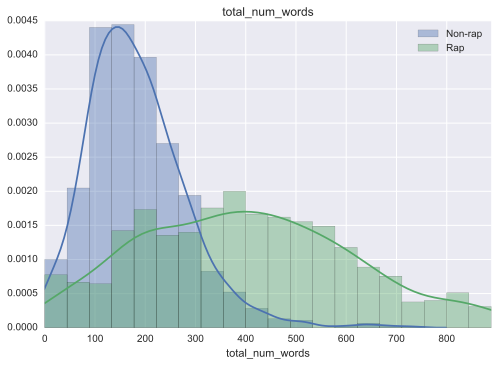

In [68]:
# Create features
total_num_words = np.zeros(len(train_data))
for i in range(len(train_data)):
	total_num_words[i] =  lyrics['tdm'][train_data.tdm_row[i],:].sum()
	
train_data.loc[:,'total_num_words'] = total_num_words
feature_distribution(train_data,'total_num_words')

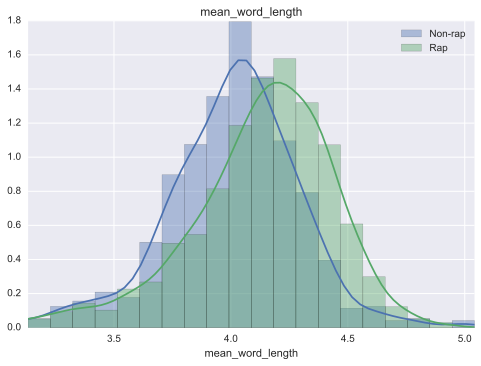

In [69]:
word_lens = np.array([len(i) for i in lyrics['unstemmed_terms']],dtype=float)
mean_word_length = np.zeros(len(train_data))
for i in range(len(train_data)):
	word_indices = lyrics['tdm'][train_data.tdm_row[i],:].nonzero()[1]
	mean_word_length[i] = np.mean(word_lens[word_indices])
train_data.loc[:,'mean_word_length'] = mean_word_length
feature_distribution(train_data,'mean_word_length')

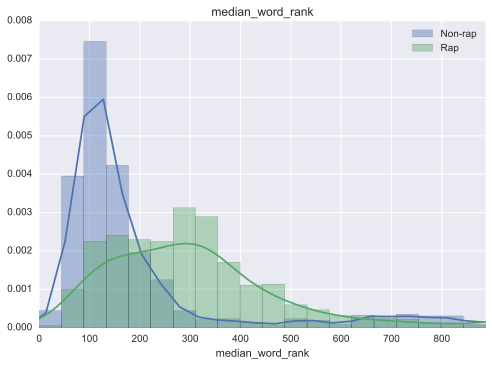

In [70]:
median_word_rank = np.zeros(len(train_data))
for i in range(len(train_data)):
	word_indices = lyrics['tdm'][train_data.tdm_row[i],:].nonzero()[1]
	median_word_rank[i] = np.median(word_indices)
train_data.loc[:,'median_word_rank'] = median_word_rank
feature_distribution(train_data,'median_word_rank')

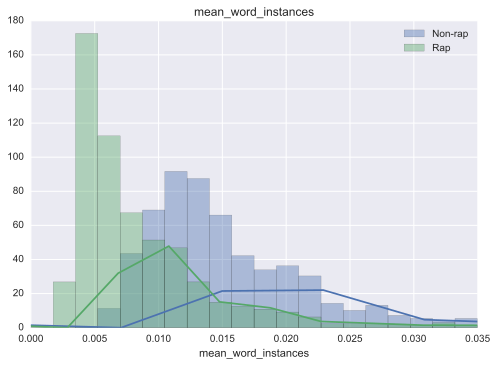

In [72]:
mean_word_instances = np.zeros(len(train_data))
for i in range(len(train_data)):
	nums = lyrics['tdm'][train_data.tdm_row[i],:].toarray()
	nz = nums[nums.nonzero()]
	mean_word_instances[i] = np.mean(nz)
train_data.loc[:,'mean_word_instances'] = np.divide(mean_word_instances,train_data.loc[:,'total_num_words'])
feature_distribution(train_data,'mean_word_instances')

In [55]:
#sfeatures = ['total_num_words','mean_word_length','rap']
#a  = sns.pairplot(train_data.loc[:,sfeatures], hue='rap', diag_kind="kde", kind="reg")
#sfeatures = ['median_word_rank','mean_word_instances','rap']
#a  = sns.pairplot(train_data.loc[:,sfeatures], hue='rap', diag_kind="kde", kind="reg")

In [73]:
features = ['total_num_words','mean_word_length','median_word_rank','mean_word_instances']
g = train_data.groupby('rap')
print g.median()[features]
print g.sem()[features]

     total_num_words  mean_word_length  median_word_rank  mean_word_instances
rap                                                                          
0              169.0          4.020202             135.0             0.014085
1              395.0          4.166667             310.0             0.006623
     total_num_words  mean_word_length  median_word_rank  mean_word_instances
rap                                                                          
0           3.072018          0.010807         11.644508             0.001456
1           6.844774          0.010696         11.871767             0.000838


In [13]:
# Fit random forest to all the data and validate on the same data (not a good idea)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data.loc[:,features],train_data.loc[:,'rap'])
prediction = clf.predict(train_data.loc[:,features])
prop_corr = np.mean(prediction == train_data.loc[:,'rap'])
print prop_corr

1.0


In [16]:
# Prepare for cross validation fittings
num_folds=10
num_instances = len(train_data)
scoring = 'accuracy'
seed = 7
kfold = cross_validation.KFold(n=num_instances, shuffle=True, n_folds=num_folds, random_state=seed)

In [74]:
# Cross validate Random forest 
clf = RandomForestClassifier(n_estimators=100)
results = cross_validation.cross_val_score(clf,train_data.loc[:,features], train_data.loc[:,'rap'], cv=kfold, scoring=scoring)
print np.mean(results)

0.81320998077


In [80]:
# Cross validate Logistic regression
scaler = preprocessing.StandardScaler().fit(train_data.loc[:,features])
train_data_scaled = scaler.transform(train_data.loc[:,features])
clf = LogisticRegression()
kfold = cross_validation.KFold(n=num_instances, shuffle=True, n_folds=num_folds, random_state=seed)
results = cross_validation.cross_val_score(clf,train_data_scaled, train_data.loc[:,'rap'], cv=kfold, scoring=scoring)
print np.mean(results)
# Check a fit
splt = cross_validation.StratifiedShuffleSplit(train_data.loc[:,'rap'], test_size=0.1,n_iter=1, random_state=7)
splt = next(iter(splt))
fitinfo = clf.fit(train_data_scaled[splt[0],:], train_data.loc[splt[0],'rap'])

0.798693776089


In [79]:
# Cross validate  SVM

scaler = preprocessing.StandardScaler().fit(train_data.loc[:,features])
train_data_scaled = scaler.transform(train_data.loc[:,features])

clf = svm.SVC()
results = cross_validation.cross_val_score(clf,train_data_scaled, train_data.loc[:,'rap'], cv=kfold, scoring=scoring)
print np.mean(results)

0.809821302941


Optimal number of features : 4


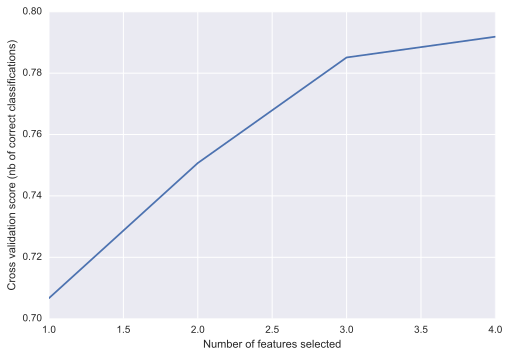

1 mean_word_instances	Importance = 0.33
2 total_num_words	Importance = 0.30
3 median_word_rank	Importance = 0.22
4 mean_word_length	Importance = 0.15


In [78]:
# Recursive number of features selection

#clf = svm.SVC(kernel='linear')
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data_scaled, train_data.loc[:,'rap'])
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(train_data.loc[:,'rap'], 2),
              scoring='accuracy')
rfecv.fit(train_data_scaled, train_data.loc[:,'rap'])

print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

order = np.argsort(clf.feature_importances_)[::-1]
for i,o in enumerate(order):
	print "%d %s\tImportance = %.2f" % (i+1, features[o], clf.feature_importances_[o])

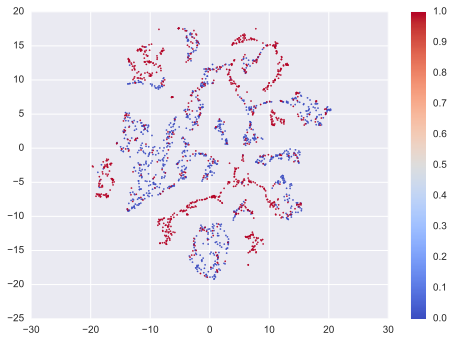

In [81]:
# TSNE embedding of the points onto a 2 plane

tsne = TSNE()
proj = tsne.fit_transform(train_data.loc[:,features])

plt.figure() 
plt.set_cmap("coolwarm")
plt.scatter(proj[:, 0], proj[:, 1],s=2, c=train_data.loc[:,'rap'], alpha=1, edgecolors='face')
plt.colorbar()
